<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400101197
Name = 'Amirreza'
Last_Name = 'Dehghani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [2]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 15378265.88it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 343887.09it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1708784.91it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15958815.22it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



### Data Exploration
Let's take a look at the classes in our dataset.

In [4]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

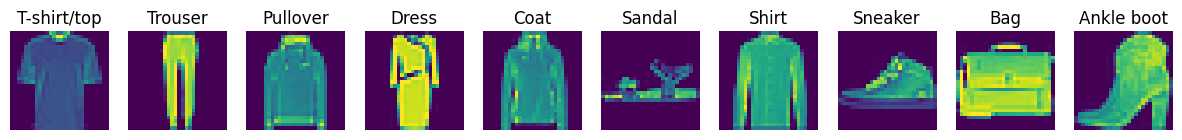

In [5]:
######################
#   YOUR CODE HERE   #
class_to_idx = {cls: idx for idx, cls in enumerate(dataset.classes)}
instances_per_class = {cls: None for cls in dataset.classes}

for img, label in dataset:
      instances_per_class[dataset.classes[label]] = img


fig, axes = plt.subplots(1, len(instances_per_class), figsize=(15, 5))

for ax, (class_name, img) in zip(axes, instances_per_class.items()):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(class_name)
        ax.axis('off')

plt.show()
######################

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [6]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [7]:
######################
#   YOUR CODE HERE   #
def determine_val_frac(n):
    if n > 50000:
        return 0.1  #  large datasets
    elif n > 10000:
        return 0.15  #  medium datasets
    else:
        return 0.2  # smaller datasets
dataset_size = len(dataset)

######################
val_frac = determine_val_frac(dataset_size) ## Set the fraction for the validation set
rand_seed = 42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 54000
number of samples in validation set: 6000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [8]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [9]:
######################
#   YOUR CODE HERE   #
def determine_batch_size(n):
    if n > 50000:
        return 128
    elif n > 5000:
        return 64
    else:
        return 32
######################
batch_size = determine_batch_size(dataset_size)## Set the batch size
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

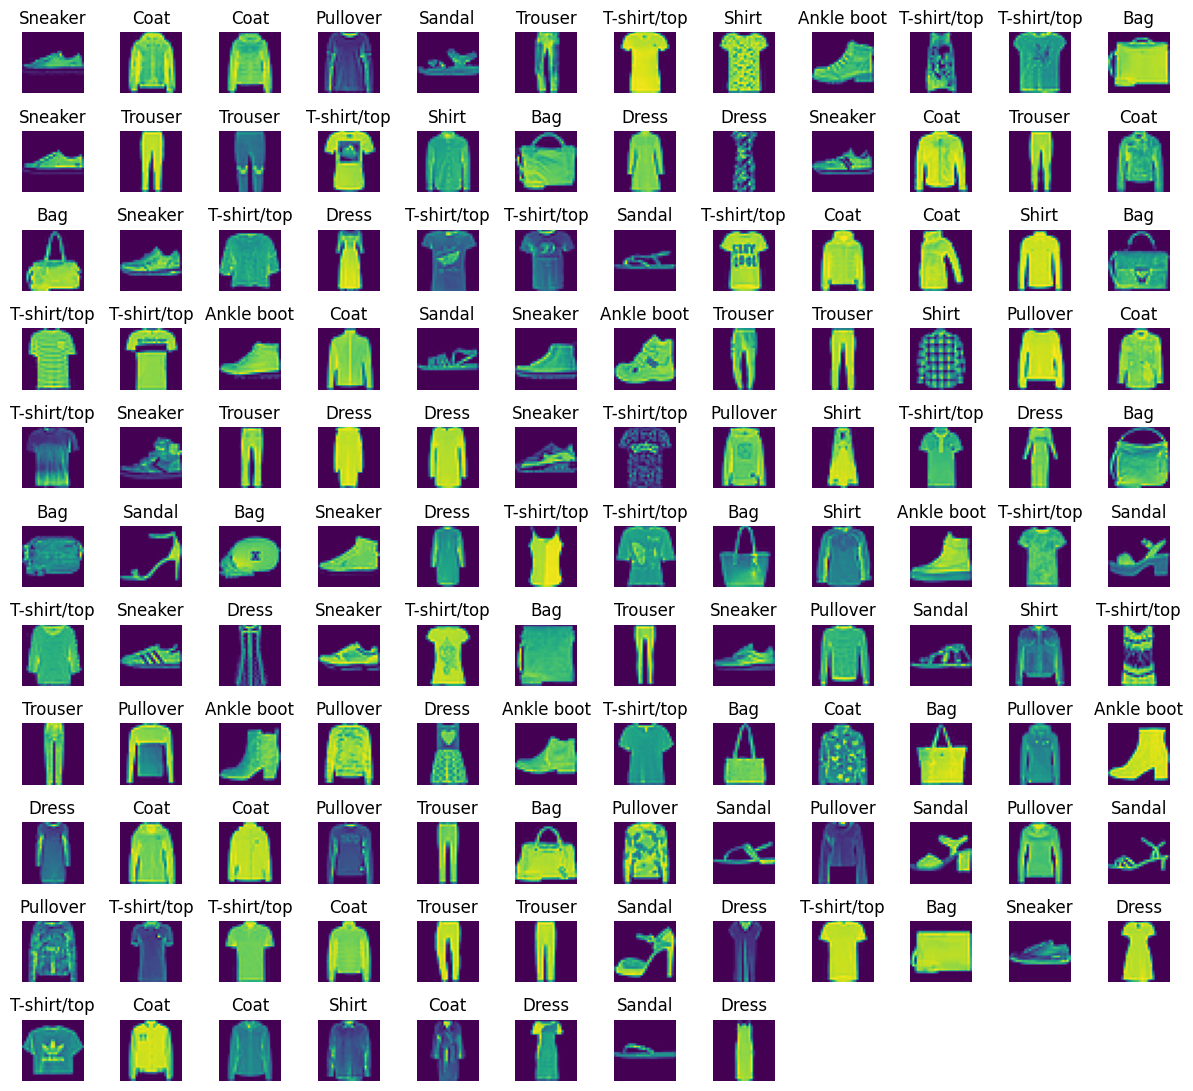

In [10]:
######################
#   YOUR CODE HERE   #
    # Get a sample batch from the dataloader
images, labels = next(iter(train_dl))

    #the grid size
grid_size = int(np.ceil(np.sqrt(len(images))))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = axes.flatten()

for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(dataset.classes[label])
        ax.axis('off')

for ax in axes[len(images):]:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()
######################

### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [11]:
# Import required packages
!pip install torchinfo
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [12]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        ######################
        #   YOUR CODE HERE   #
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(28 * 8 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        ######################

    def forward(self, X):
        ######################
        #   YOUR CODE HERE   #
        X = self.pool(F.relu(self.conv1(X)))  # First convolutional layer + ReLU + Max pooling
        X = self.pool(F.relu(self.conv2(X)))  # Second convolutional layer + ReLU + Max pooling
        X = X.view(-1, 28 * 8 * 7)            # Flatten the tensor
        X = F.relu(self.fc1(X))               # Fully connected layer + ReLU
        X = self.fc2(X)                       # Output layer
        return X

        ######################

In [13]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [14]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 28, 28]         160
├─MaxPool2d: 1-2                         [128, 16, 14, 14]         --
├─Conv2d: 1-3                            [128, 32, 14, 14]         4,640
├─MaxPool2d: 1-4                         [128, 32, 7, 7]           --
├─Linear: 1-5                            [128, 128]                200,832
├─Linear: 1-6                            [128, 10]                 1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
Total mult-adds (M): 158.34
Input size (MB): 0.40
Forward/backward pass size (MB): 19.41
Params size (MB): 0.83
Estimated Total Size (MB): 20.64

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [15]:
class SGD:
    def __init__(self, parameters, lr=0.001):
        self.parameters = list(parameters)
        self.lr = lr

    def step(self):
        for param in self.parameters:
            param.data -= self.lr * param.grad.data

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.data.zero_()

def cross_entropy_loss(outputs, labels):

    # Compute softmax to get probabilities
    probs = torch.softmax(outputs, dim=1)

    # Gather the probabilities corresponding to the labels
    batch_size = outputs.size(0)
    idxs = torch.arange(batch_size)
    label_probs = probs[idxs, labels]

    # Take the logarithm
    log_probs = torch.log(label_probs)

    # Compute the negative log likelihood
    neg_log_likelihood = -log_probs

    # Compute the mean loss
    loss = neg_log_likelihood.mean()

    return loss


In [16]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    ######################
    #   YOUR CODE HERE   #

    #SGD optimizer
    optimizer = SGD(model.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for batch_idx, (inputs, labels) in enumerate(train_dl):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cross_entropy_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            train_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()

        # Calculate average loss and accuracy
        train_losses.append(train_loss / total_train)
        train_acc = correct_train / total_train
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0.00001

        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = cross_entropy_loss(outputs, labels)

                # Accumulate the loss
                val_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)

                # Compute validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()

        # Calculate average loss and accuracy
        val_losses.append(val_loss / total_val)
        val_acc = correct_val / total_val
        val_accuracies.append(val_acc)

        # Print progress
        print(f'Epoch [{epoch+1}/{n_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}')

    ######################

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [17]:
######################
#   YOUR CODE HERE   #
######################
num_epochs =25 # Number of training epochs
loss_fn =nn.CrossEntropyLoss()  # Define the loss function
opt_fn = 'SGD' # Select an optimizer
lr = 0.001  # Set the learning rate

In [18]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch [1/25], Train Loss: 2.2861, Train Acc: 0.1488, Val Loss: 2.2642, Val Acc: 0.2025
Epoch [2/25], Train Loss: 2.2343, Train Acc: 0.3145, Val Loss: 2.1964, Val Acc: 0.4545
Epoch [3/25], Train Loss: 2.1225, Train Acc: 0.5151, Val Loss: 2.0268, Val Acc: 0.5232
Epoch [4/25], Train Loss: 1.8490, Train Acc: 0.5337, Val Loss: 1.6401, Val Acc: 0.5560
Epoch [5/25], Train Loss: 1.4038, Train Acc: 0.6036, Val Loss: 1.2094, Val Acc: 0.6630
Epoch [6/25], Train Loss: 1.0686, Train Acc: 0.6748, Val Loss: 0.9707, Val Acc: 0.6953
Epoch [7/25], Train Loss: 0.8911, Train Acc: 0.7114, Val Loss: 0.8356, Val Acc: 0.7265
Epoch [8/25], Train Loss: 0.7907, Train Acc: 0.7317, Val Loss: 0.7591, Val Acc: 0.7370
Epoch [9/25], Train Loss: 0.7320, Train Acc: 0.7447, Val Loss: 0.7132, Val Acc: 0.7462
Epoch [10/25], Train Loss: 0.6947, Train Acc: 0.7534, Val Loss: 0.6812, Val Acc: 0.7517
Epoch [11/25], Train Loss: 0.6691, Train Acc: 0.7598, Val Loss: 0.6569, Val Acc: 0.7605
Epoch [12/25], Train Loss: 0.6499, Train 

### Plot loss and accuracy

In [19]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

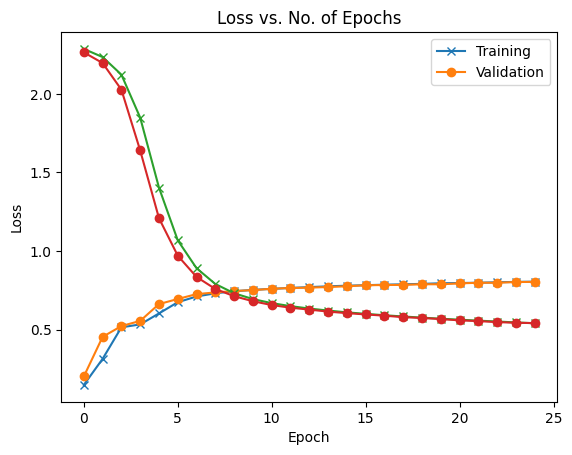

In [20]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [21]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [22]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 25 # Max number of training epochs
lr = 0.001# Set the learning rate

In [23]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Epoch [1/25], Train Loss: 0.5355, Train Acc: 0.8078, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [2/25], Train Loss: 0.5305, Train Acc: 0.8101, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [3/25], Train Loss: 0.5253, Train Acc: 0.8105, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [4/25], Train Loss: 0.5202, Train Acc: 0.8126, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [5/25], Train Loss: 0.5154, Train Acc: 0.8149, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [6/25], Train Loss: 0.5108, Train Acc: 0.8167, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [7/25], Train Loss: 0.5059, Train Acc: 0.8181, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [8/25], Train Loss: 0.5020, Train Acc: 0.8199, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [9/25], Train Loss: 0.4970, Train Acc: 0.8221, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [10/25], Train Loss: 0.4930, Train Acc: 0.8233, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [11/25], Train Loss: 0.4887, Train Acc: 0.8244, Val Loss: 0.0000, Val Acc: 0.0000
Epoch [12/25], Train Loss: 0.4843, Train 

### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

In [24]:
######################
#   YOUR CODE HERE   #

def view_prediction(image, label, probabilities, class_names):

    # Convert image tensor to numpy array
    image = np.transpose(image.numpy(), (1, 2, 0))

    # Plot image
    plt.imshow(image)
    plt.axis('off')

    # Display label and predicted probabilities
    plt.title(f'Label: {class_names[label]}, Predicted: {class_names[np.argmax(probabilities)]}')
    plt.show()
######################

### Save the model

In [25]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [26]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [27]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    ######################
    #   YOUR CODE HERE   #
    correct = 0
    total = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    return test_accuracy
    ######################

In [28]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.8335
